### Install Packages

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip 
!{sys.executable} -m pip install --upgrade wheel setuptools build
!{sys.executable} -m pip install -r requirements.txt

### Load Packages

In [1]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import project_tests
import project_helper

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)


## Data Bundle
Register data bundle in zipline

In [2]:
import os
import project_helper
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), 'data', 'project_4_eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


## Build Pipeline Engine


In [3]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

# "universe" is a screen (dictionary) for deciding what to include from all data
universe = AverageDollarVolume(window_length=120).top(500)
trading_calendar = get_calendar('NYSE') 
#load data bundle
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data
Fetch the stocks at the end of the period of the universe. These tickers will also be used to generate return data for risk model

In [4]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()

## Get Returns
Build a data portal to access historical return data

In [5]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

The helper function `get_pricing` generalizes the code for obtaining pricing from data portal

In [6]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

### View Data
Use `get_pricing` function to get returns data from the past five years from end date defined above

In [7]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns.head(5)

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.00843652,0.01423027,0.02670202,0.00714639,0.00000000,0.00199434,0.00416541,0.00164769,-0.00712736,-0.00581846,...,-0.00183775,-0.00561865,0.00546091,-0.00404361,-0.01395259,0.00000000,0.01245693,-0.00018145,-0.01045802,0.00000000
2011-01-10 00:00:00+00:00,-0.00417428,0.00619534,0.00743543,0.01885158,0.00000000,-0.00571429,-0.00889600,-0.00885384,0.02871411,0.00292626,...,0.00094687,0.00781438,-0.00608100,0.01046585,0.00973303,0.00000000,0.00143979,0.00778351,-0.01794496,0.00000000
2011-01-11 00:00:00+00:00,-0.00188630,-0.04364361,-0.00592730,-0.00236744,0.00000000,0.00978303,-0.00206747,0.01371668,0.00060680,0.00875316,...,0.00131385,0.01017933,0.00744242,0.00735141,0.00611644,0.00000000,-0.00646974,0.03567570,0.00746728,0.00000000
2011-01-12 00:00:00+00:00,0.01725375,-0.00823708,0.01338721,0.00813289,0.00000000,-0.00597922,-0.00101061,0.02296913,0.01795027,0.00025710,...,0.00498609,0.01566621,0.01176334,0.02718194,0.00438630,0.00000000,0.00263106,0.01474083,-0.01190269,0.00000000
2011-01-13 00:00:00+00:00,-0.00455851,0.00095465,0.00303109,0.00365656,0.00000000,0.01492537,-0.00445119,-0.00040011,-0.00571905,-0.00501221,...,0.03049927,-0.00321668,0.00169383,0.00054651,-0.01823475,0.00000000,-0.00508430,-0.00466453,-0.00917796,0.00000000


# Statistical Risk Model
Create statistical risk model using PCA
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [8]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    return pca


### View Data
Run PCA to get the principal components

In [9]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

pca.components_

array([[-0.04316847, -0.05874471, -0.03433256, ..., -0.03843904,
        -0.06092493, -0.01367163],
       [ 0.01955111,  0.19637679,  0.03451503, ...,  0.01749339,
        -0.01044197,  0.01892192],
       [-0.00993375,  0.07868756,  0.01133839, ..., -0.0157519 ,
         0.01261759,  0.01867875],
       ...,
       [-0.01174265,  0.01398085,  0.05143999, ...,  0.04125323,
         0.0035229 ,  0.03682367],
       [ 0.00526925, -0.04680674,  0.05716915, ...,  0.00671842,
        -0.02193923,  0.00833979],
       [-0.00535269, -0.01599057,  0.08414961, ..., -0.01540844,
         0.02188794,  0.01500221]])

Plot PCA's percent of variance explained by each factor

<Container object of 20 artists>

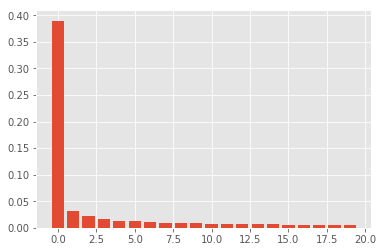

In [10]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

The first factor dominates. Even though each factor is unknown, it is possible to guess at the interpretations based on the first principal component

## Factor Betas
Implement `factor_betas` to get the factor betas from the PCA model.

In [11]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)

### View Data
View Factor Betas in this model

In [12]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas'].head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),-0.04316847,0.01955111,-0.00993375,0.01054038,-0.01819821,0.01074517,0.00112915,0.03973914,-0.01380519,0.01273651,-0.02384028,-0.00141663,0.02099338,0.03460997,-0.03048936,0.03360635,-0.01142920,-0.01174265,0.00526925,-0.00535269
Equity(1 [AAL]),-0.05874471,0.19637679,0.07868756,0.08209582,0.34847826,-0.13808246,0.07129285,0.10524788,-0.04588957,-0.08547793,0.00328328,0.10534284,0.06721603,-0.04405955,-0.02231617,0.01726309,-0.03310836,0.01398085,-0.04680674,-0.01599057
Equity(2 [AAP]),-0.03433256,0.03451503,0.01133839,-0.02543666,-0.00817211,-0.01318319,-0.06095238,0.00654915,-0.03265404,-0.01351522,0.02896685,0.03836520,-0.04960451,-0.00524576,-0.02196994,0.02976718,-0.01163585,0.05143999,0.05716915,0.08414961
Equity(3 [AAPL]),-0.03409988,-0.00139319,0.03946700,-0.01721303,-0.03046983,-0.01757067,0.02325117,0.01142987,-0.02656849,-0.00771904,0.02686350,0.00731877,0.00481832,0.01288623,0.05256513,-0.07344470,-0.03179158,0.09079374,-0.01118851,0.04291373
Equity(4 [ABBV]),-0.01803099,0.02568151,0.00435183,-0.07078179,0.01319937,0.05427710,-0.01567842,0.04046172,-0.01245487,-0.03515086,-0.05132433,-0.04041614,-0.05120320,-0.01858166,-0.01126857,-0.04200714,0.01588559,0.04598554,0.01599288,0.06587978


## Factor Returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [13]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)

### View Data
Let's see what these factor returns looks like over time.

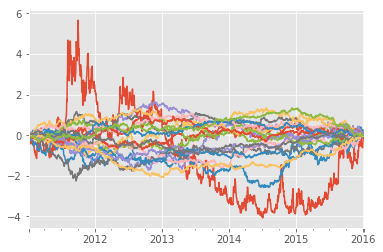

In [14]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None)

## Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [15]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    
    return np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)

### View Data

In [16]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[14.01830425,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.10591127,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.77099145,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.61798821,  0.        ,
         0.        ,  0.        ,  0.        ,  

## Idiosyncratic Variance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [17]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    residuals_ = (returns - common_returns_)
    return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)

### View Data

In [18]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix'].head()

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
Equity(0 [A]),0.02272535,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(1 [AAL]),0.00000000,0.05190083,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(2 [AAP]),0.00000000,0.00000000,0.05431181,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(3 [AAPL]),0.00000000,0.00000000,0.00000000,0.04801884,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(4 [ABBV]),0.00000000,0.00000000,0.00000000,0.00000000,0.03040361,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


## Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [20]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    #TODO: Implement function
    
    return pd.DataFrame(data=np.diag(idiosyncratic_var_matrix),index=returns.columns)



### View Data

In [21]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector'].head(5)

,0
Equity(0 [A]),0.02272535
Equity(1 [AAL]),0.05190083
Equity(2 [AAP]),0.05431181
Equity(3 [AAPL]),0.04801884
Equity(4 [ABBV]),0.03040361


## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [23]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    X = weights
    B = factor_betas
    F = factor_cov_matrix
    S = idiosyncratic_var_matrix
    return np.sqrt(X.T.dot(B.dot(F).dot(B.T) + S).dot(X))[0][0]

### View Data
Let's see what the portfolio risk would be if we had even weights across all stocks.

In [24]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.16094824687040465

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 1 Year Factor
`momentum_1yr` generates a code that has a hypothesis of "Higher past 12-month (252 days) returns are proportional to future return.

In [25]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

## Mean Reversion 5 Day Sector Neutral Factor
`mean_reversion_5day_sector_neutral` implements the hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." 

In [26]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    
    #TODO: Implement function
    
    return -Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

### View Data
Let's see what some of the factor data looks like. For calculating factors, we'll be looking back 2 years.

**Note:** _Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open._

In [27]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
sector = project_helper.Sector()
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date).head(5)

Mean_Reversion_5Day_Sector_Neutral
2014-01-03 00:00:00+00:00 Equity(0 [A])                             0.85326482
                          Equity(1 [AAL])                           1.62630815
                          Equity(2 [AAP])                           0.64906469
                          Equity(3 [AAPL])                          1.40752230
                          Equity(4 [ABBV])                          1.45857233

## Mean Reversion 5 Day Sector Neutral Smoothed Factor
The `mean_reversion_5day_sector_neutral` function to get the unsmoothed factor, then use `SimpleMovingAverage` function to smooth it the Mean Reversion Sector Neutral factor

In [28]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    
    #TODO: Implement function
    factor = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    factor_smoothed = (SimpleMovingAverage(inputs=[factor], window_length=window_length).
                        rank().
                        zscore())

    return factor_smoothed

### View Data
Display smoothed factor

In [29]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date).head(5)

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      1.11580784
                          Equity(1 [AAL])                                    1.72840822
                          Equity(2 [AAP])                                    1.34188655
                          Equity(3 [AAPL])                                   0.91160771
                          Equity(4 [ABBV])                                   0.96265774

## Overnight Sentiment Factor
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [30]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Overnight Sentiment Smoothed Factor
`overnight_sentiment_smoothed` smoothes Overnight Sentiment Factor

In [31]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Combine the Factors to a single Pipeline
Add all new factors to the pipeline

In [32]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                             0.85326482   
                          Equity(1 [AAL])                           1.62630815   
                          Equity(2 [AAP])                           0.64906469   
                          Equity(3 [AAPL])                          1.40752230   
                          Equity(4 [ABBV])                          1.45857233   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      1.11580784   
                          Equity(1 [AAL])                                    1.72840822   
                          Equity(2 [AAP])                                    1.34188655   
                          Equity(3 [AAPL])                                   0.91160771   
                          Equity(4 [ABBV])                                   0.96265774   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-03 00:00:00+00:00 Equity(0 [A])       1.49939067           0.70659131   
                          Equity(1 [AAL])     1.60279693          -1.70668978   
                          Equity(2 [AAP])     0.37669421           0.03261191   
                          Equity(3 [AAPL])   -1.48461835          -1.67770142   
                          Equity(4 [ABBV])    0.91588396          -1.47478289   

                                            Overnight_Sentiment_Smoothed  
2014-01-03 00:00:00+00:00 Equity(0 [A])                       1.11242837  
                          Equity(1 [AAL])                    -1.72843105  
                          Equity(2 [AAP])                    -0.62687332  
                          Equity(3 [AAPL])                    0.53990823  
                          Equity(4 [ABBV])                   -0.06160027

# Evaluate Alpha Factors
*Note:* _We're evaluating the alpha factors using delay of 1_
## Get Pricing Data

In [33]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

## Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [34]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Quantile Analysis
### Factor Returns
Let's view the factor returns over time.

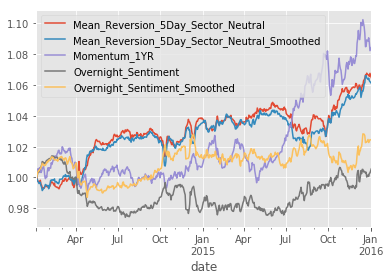

In [35]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile
Analyze if the alpha factors are monotic in quantiles by looking at basis points for the factor returns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5aad32710>,
      dtype=object)

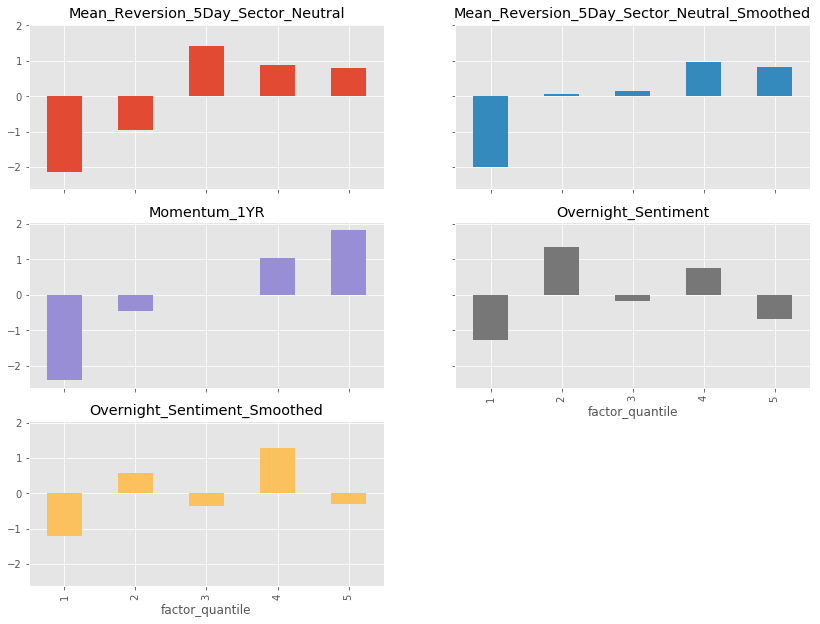

In [36]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

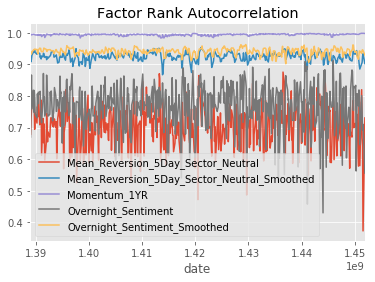

In [37]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

## Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. 

`sharpe_ratio` will calculate the sharpe ratio of factor returns

In [39]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    df_sharpe =pd.Series(annualization_factor * factor_returns.mean()/factor_returns.std())
    return df_sharpe

### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [40]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral            1.37000000
Mean_Reversion_5Day_Sector_Neutral_Smoothed   1.27000000
Momentum_1YR                                  1.13000000
Overnight_Sentiment                           0.12000000
Overnight_Sentiment_Smoothed                  0.45000000
dtype: float64

## The Combined Alpha Vector
## Features and Labels
Add some features that may help model to make predictions
### "Universal" Quant Features
To capture the universe, we'll use the following as features:
- Stock Volatility 20d, 120d
- Stock Dollar Volume 20d, 120d
- Sector

In [41]:
from zipline.pipeline.factors import CustomFactor, DailyReturns, Returns, SimpleMovingAverage, AnnualizedVolatility
pipeline.add(AnnualizedVolatility(window_length=20, mask=universe).rank().zscore(), 'volatility_20d')
pipeline.add(AnnualizedVolatility(window_length=120, mask=universe).rank().zscore(), 'volatility_120d')
pipeline.add(AverageDollarVolume(window_length=20, mask=universe).rank().zscore(), 'adv_20d')
pipeline.add(AverageDollarVolume(window_length=120, mask=universe).rank().zscore(), 'adv_120d')
pipeline.add(sector, 'sector_code')

### Regime Features
We are going to try to capture market-wide regimes. To do that, we'll use the following features:
- High and low volatility 20d, 120d  
- High and low dispersion 20d, 120d  

The `MarketDispersion` computes the dispersion of return for each day

In [42]:
class MarketDispersion(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True

    def compute(self, today, assets, out, returns):
        # returns are days in rows, assets across columns
        out[:] = np.sqrt(np.nanmean((returns - np.nanmean(returns))**2))


pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=20), 'dispersion_20d')
pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=120), 'dispersion_120d')

`MarketVolatility` computes the volatility of return for each day

In [43]:
class MarketVolatility(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True
    
    def compute(self, today, assets, out, returns):
        mkt_returns = np.nanmean(returns, axis=1)
        out[:] = np.sqrt(260.* np.nanmean((mkt_returns-np.nanmean(mkt_returns))**2))


pipeline.add(MarketVolatility(window_length=20), 'market_vol_20d')
pipeline.add(MarketVolatility(window_length=120), 'market_vol_120d')

### Target
The target of the alpha combiner will go forward 1-week return and quantized

In [44]:
pipeline.add(Returns(window_length=5, mask=universe).quantiles(2), 'return_5d')
pipeline.add(Returns(window_length=5, mask=universe).quantiles(25), 'return_5d_p')

### Date Features
Let's make columns for the trees to split on that might capture trader/investor behavior due to calendar anomalies.

In [45]:
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors['is_Janaury'] = all_factors.index.get_level_values(0).month == 1
all_factors['is_December'] = all_factors.index.get_level_values(0).month == 12
all_factors['weekday'] = all_factors.index.get_level_values(0).weekday
all_factors['quarter'] = all_factors.index.get_level_values(0).quarter
all_factors['qtr_yr'] = all_factors.quarter.astype('str') + '_' + all_factors.index.get_level_values(0).year.astype('str')
all_factors['month_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BM'))
all_factors['month_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BMS'))
all_factors['qtr_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQ'))
all_factors['qtr_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQS'))

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                             0.85326482   
                          Equity(1 [AAL])                           1.62630815   
                          Equity(2 [AAP])                           0.64906469   
                          Equity(3 [AAPL])                          1.40752230   
                          Equity(4 [ABBV])                          1.45857233   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      1.11580784   
                          Equity(1 [AAL])                                    1.72840822   
                          Equity(2 [AAP])                                    1.34188655   
                          Equity(3 [AAPL])                                   0.91160771   
                          Equity(4 [ABBV])                                   0.96265774   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-03 00:00:00+00:00 Equity(0 [A])       1.49939067           0.70659131   
                          Equity(1 [AAL])     1.60279693          -1.70668978   
                          Equity(2 [AAP])     0.37669421           0.03261191   
                          Equity(3 [AAPL])   -1.48461835          -1.67770142   
                          Equity(4 [ABBV])    0.91588396          -1.47478289   

                                            Overnight_Sentiment_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                       1.11242837   
                          Equity(1 [AAL])                    -1.72843105   
                          Equity(2 [AAP])                    -0.62687332   
                          Equity(3 [AAPL])                    0.53990823   
                          Equity(4 [ABBV])                   -0.06160027   

                                              adv_120d     adv_20d  \
2014-01-03 00:00:00+00:00 Equity(0 [A])     1.51101834  1.50377125   
                          Equity(1 [AAL])   1.48927707  1.56899506   
                          Equity(2 [AAP])  -0.58339077 -0.21378917   
                          Equity(3 [AAPL])  1.72843105  1.72843105   
                          Equity(4 [ABBV])  1.03271038  1.35158235   

                                            dispersion_120d  dispersion_20d  \
2014-01-03 00:00:00+00:00 Equity(0 [A])          0.01191693      0.01042331   
                          Equity(1 [AAL])        0.01191693      0.01042331   
                          Equity(2 [AAP])        0.01191693      0.01042331   
                          Equity(3 [AAPL])       0.01191693      0.01042331   
                          Equity(4 [ABBV])       0.01191693      0.01042331   

                                            market_vol_120d    ...      \
2014-01-03 00:00:00+00:00 Equity(0 [A])          0.10704749    ...       
                          Equity(1 [AAL])        0.10704749    ...       
                          Equity(2 [AAP])        0.10704749    ...       
                          Equity(3 [AAPL])       0.10704749    ...       
                          Equity(4 [ABBV])       0.10704749    ...       

                                            volatility_20d  is_Janaury  \
2014-01-03 00:00:00+00:00 Equity(0 [A])        -1.51101834        True   
                          Equity(1 [AAL])       1.68494851        True   
                          Equity(2 [AAP])       1.16315800        True   
                          Equity(3 [AAPL])      0.67760295        True   
                          Equity(4 [ABBV])      1.03271038        True   

                                            is_December  weekday  quarter  \
2014-01-03 00:00:00+00:00 Equity(0 [A])           False        4        1   
                          Equity(1 [AAL])         False        4        1   
                          Equity(2 [AAP])  

### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [46]:
#Edited
sector_lookup = pd.read_csv(
    os.path.join(os.getcwd(),"data" ,'project_7_sector', 'labels.csv'),
    index_col='Sector_i')['Sector'].to_dict()
sector_lookup

sector_columns = []
for sector_i, sector_name in sector_lookup.items():
    secotr_column = 'sector_{}'.format(sector_name)
    sector_columns.append(secotr_column)
    all_factors[secotr_column] = (all_factors['sector_code'] == sector_i)

all_factors[sector_columns].head()

sector_Healthcare  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                 True   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   
                          Equity(3 [AAPL])             False   
                          Equity(4 [ABBV])              True   

                                           sector_Technology  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                False   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   
                          Equity(3 [AAPL])              True   
                          Equity(4 [ABBV])             False   

                                           sector_Consumer Defensive  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                        False   
                          Equity(1 [AAL])                      False   
                          Equity(2 [AAP])                      False   
                          Equity(3 [AAPL])                     False   
                          Equity(4 [ABBV])                     False   

                                           sector_Industrials  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])                True   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])              False   
                          Equity(4 [ABBV])              False   

                                           sector_Utilities  \
2014-01-03 00:00:00+00:00 Equity(0 [A])               False   
                          Equity(1 [AAL])             False   
                          Equity(2 [AAP])             False   
                          Equity(3 [AAPL])            False   
                          Equity(4 [ABBV])            False   

                                           sector_Financial Services  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                        False   
                          Equity(1 [AAL])                      False   
                          Equity(2 [AAP])                      False   
                          Equity(3 [AAPL])                     False   
                          Equity(4 [ABBV])                     False   

                                           sector_Real Estate  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])               False   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])              False   
                          Equity(4 [ABBV])              False   

                                           sector_Communication Services  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                            False   
                          Equity(1 [AAL])                          False   
                          Equity(2 [AAP])                          False   
                          Equity(3 [AAPL])                         False   
                          Equity(4 [ABBV])                         False   

                                           sector_Consumer Cyclical  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                       False   
                          Equity(1 [AAL])                     False   
                          Equity(2 [AAP])                      True   
                          Equity(3 [AAPL])                    False   
                          Equity(4 [ABBV])                    False   

                                           sector_Energy  \
2014-01-03 00:00:00+00:00 Equity(0 [A])            False   
                          Equity(1 [AAL])          False   
                          Equity(2 [AAP])          False   
                          Equity(3 [AAPL])         False   
                          Equity(4 [ABBV])         False   

 

### Shift Target
We'll use shifted 5 day returns for training the model

In [47]:
all_factors['target'] = all_factors.groupby(level=1)['return_5d'].shift(-5)

all_factors[['return_5d','target']].reset_index().sort_values(['level_1', 'level_0']).head(10)

,level_0,level_1,return_5d,target
0,2014-01-03 00:00:00+00:00,Equity(0 [A]),0,1.00000000
478,2014-01-06 00:00:00+00:00,Equity(0 [A]),1,1.00000000
956,2014-01-07 00:00:00+00:00,Equity(0 [A]),1,1.00000000
1434,2014-01-08 00:00:00+00:00,Equity(0 [A]),1,0.00000000
1912,2014-01-09 00:00:00+00:00,Equity(0 [A]),1,0.00000000
2390,2014-01-10 00:00:00+00:00,Equity(0 [A]),1,0.00000000
2868,2014-01-13 00:00:00+00:00,Equity(0 [A]),1,0.00000000
3346,2014-01-14 00:00:00+00:00,Equity(0 [A]),1,1.00000000
3824,2014-01-15 00:00:00+00:00,Equity(0 [A]),0,1.00000000
4302,2014-01-16 00:00:00+00:00,Equity(0 [A]),0,1.00000000


### IID Check of Target
Let's see if the returns are independent and identically distributed.

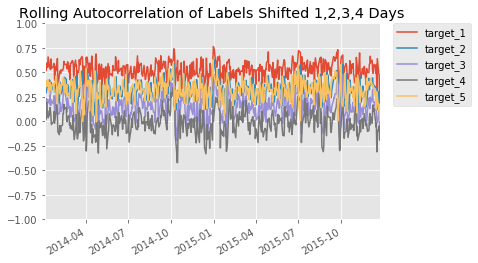

In [48]:
from scipy.stats import spearmanr


def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]


all_factors['target_p'] = all_factors.groupby(level=1)['return_5d_p'].shift(-5)
all_factors['target_1'] = all_factors.groupby(level=1)['return_5d'].shift(-4)
all_factors['target_2'] = all_factors.groupby(level=1)['return_5d'].shift(-3)
all_factors['target_3'] = all_factors.groupby(level=1)['return_5d'].shift(-2)
all_factors['target_4'] = all_factors.groupby(level=1)['return_5d'].shift(-1)
all_factors['target_5'] = all_factors.groupby(level=1)['return_5d'].shift(-7)
g = all_factors.dropna().groupby(level=0)
for i in range(5):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

The autocorrelation increases as we increase the shifted days. The autocorrelations are positive for target 1, 2, 3 and around 0 for target 4, meaning future (5d) returns tend to move to the same direction as the past (5d) returns while they affect more by past returns that have closer dates to the current date.

### Train/Valid/Test Splits
The function `train_valid_test_split` splits the input samples, `all_x`, and targets values, `all_y` into a train, validation, and test dataset. The proportion sizes are `train_size`, `valid_size`, `test_size` respectively.  Please note that the data are split by time sequence which are different from traditional machine learning models (random splits)

In [49]:
from sklearn.model_selection import train_test_split
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generate the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size == 1.0
    
    indexes = all_x.index.levels[0].tolist()
    train_end = int(len(indexes)*train_size)
    valid_end = train_end + int(len(indexes)*valid_size)
    
    X_train, X_valid, X_test = all_x.loc[indexes[:train_end]], all_x.loc[indexes[train_end:valid_end]], all_x.loc[indexes[valid_end:]]
    y_train, y_valid, y_test = all_y.loc[indexes[:train_end]], all_y.loc[indexes[train_end:valid_end]], all_y.loc[indexes[valid_end:]]
    return X_train, X_valid, X_test, y_train, y_valid, y_test

Fetch the features and split the data into a train, validation, and test set. 

In [50]:
features = [
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d',
    'is_Janaury', 'is_December', 'weekday',
    'month_end', 'month_start', 'qtr_end', 'qtr_start'] + sector_columns
target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_train.head()

Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      1.11580784   
                          Equity(1 [AAL])                                    1.72840822   
                          Equity(2 [AAP])                                    1.34188655   
                          Equity(3 [AAPL])                                   0.91160771   
                          Equity(4 [ABBV])                                   0.96265774   

                                            Momentum_1YR  \
2014-01-03 00:00:00+00:00 Equity(0 [A])       1.49939067   
                          Equity(1 [AAL])     1.60279693   
                          Equity(2 [AAP])     0.37669421   
                          Equity(3 [AAPL])   -1.48461835   
                          Equity(4 [ABBV])    0.91588396   

                                            Overnight_Sentiment_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                       1.11242837   
                          Equity(1 [AAL])                    -1.72843105   
                          Equity(2 [AAP])                    -0.62687332   
                          Equity(3 [AAPL])                    0.53990823   
                          Equity(4 [ABBV])                   -0.06160027   

                                              adv_120d     adv_20d  \
2014-01-03 00:00:00+00:00 Equity(0 [A])     1.51101834  1.50377125   
                          Equity(1 [AAL])   1.48927707  1.56899506   
                          Equity(2 [AAP])  -0.58339077 -0.21378917   
                          Equity(3 [AAPL])  1.72843105  1.72843105   
                          Equity(4 [ABBV])  1.03271038  1.35158235   

                                            dispersion_120d  dispersion_20d  \
2014-01-03 00:00:00+00:00 Equity(0 [A])          0.01191693      0.01042331   
                          Equity(1 [AAL])        0.01191693      0.01042331   
                          Equity(2 [AAP])        0.01191693      0.01042331   
                          Equity(3 [AAPL])       0.01191693      0.01042331   
                          Equity(4 [ABBV])       0.01191693      0.01042331   

                                            market_vol_120d  market_vol_20d  \
2014-01-03 00:00:00+00:00 Equity(0 [A])          0.10704749      0.10059772   
                          Equity(1 [AAL])        0.10704749      0.10059772   
                          Equity(2 [AAP])        0.10704749      0.10059772   
                          Equity(3 [AAPL])       0.10704749      0.10059772   
                          Equity(4 [ABBV])       0.10704749      0.10059772   

                                            volatility_20d  \
2014-01-03 00:00:00+00:00 Equity(0 [A])        -1.51101834   
                          Equity(1 [AAL])       1.68494851   
                          Equity(2 [AAP])       1.16315800   
                          Equity(3 [AAPL])      0.67760295   
                          Equity(4 [ABBV])      1.03271038   

                                                    ...            \
2014-01-03 00:00:00+00:00 Equity(0 [A])             ...             
                          Equity(1 [AAL])           ...             
                          Equity(2 [AAP])           ...             
                          Equity(3 [AAPL])          ...             
                          Equity(4 [ABBV])          ...             

                                           sector_Technology  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                False   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   
                          Equity(3 [AAPL])              True   
                          Equity(4 [ABBV])             False   

                                           sector_Consumer Defensive  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                        

## Random Forests
### Visualize a Simple Tree
Let's see how a single tree would look using our data.

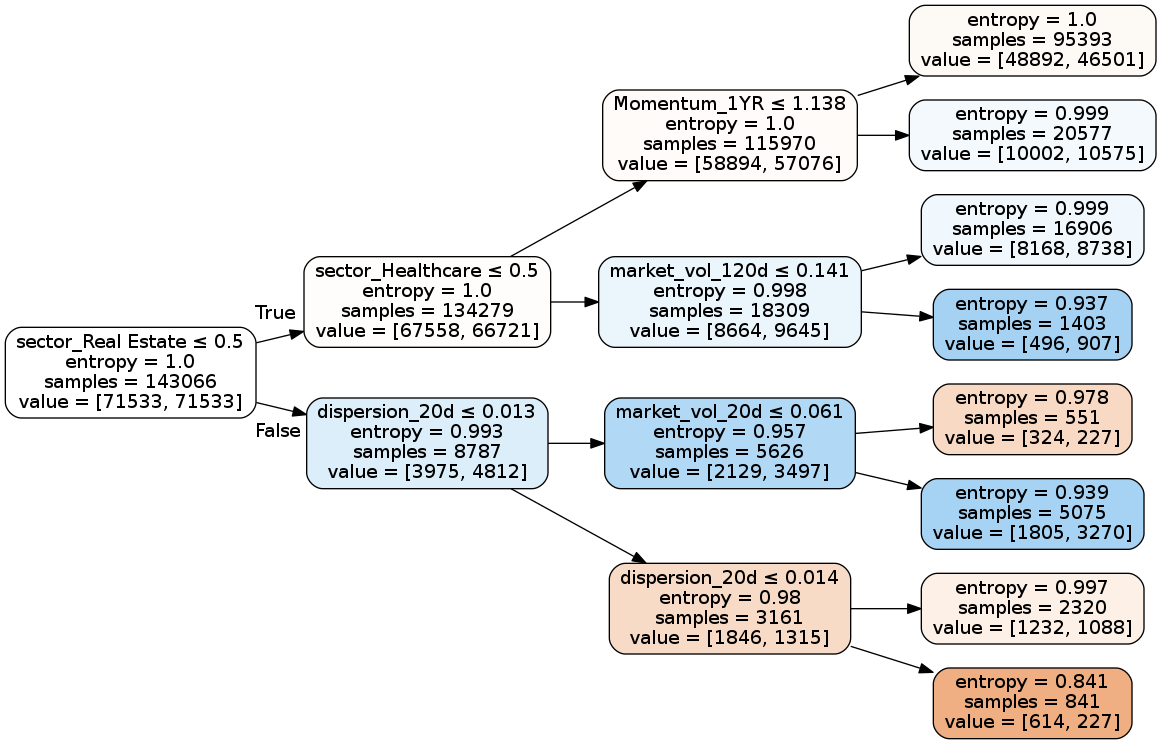

      Feature                                         Importance
 1. dispersion_20d                              (0.5249399076062287)
 2. market_vol_20d                              (0.12847457638837417)
 3. market_vol_120d                             (0.10359493491833213)
 4. sector_Real Estate                          (0.09921872097966347)
 5. sector_Healthcare                           (0.08849376912935007)
 6. Momentum_1YR                                (0.05527809097805165)
 7. sector_Basic Materials                      (0.0)
 8. weekday                                     (0.0)
 9. Overnight_Sentiment_Smoothed                (0.0)
10. adv_120d                                    (0.0)
11. adv_20d                                     (0.0)
12. dispersion_120d                             (0.0)
13. volatility_20d                              (0.0)
14. is_Janaury                                  (0.0)
15. is_December                                 (0.0)
16. month_end                 

In [51]:
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier
clf_random_state = 0

simple_clf = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=clf_random_state)
simple_clf.fit(X_train, y_train)

display(project_helper.plot_tree_classifier(simple_clf, feature_names=features))
project_helper.rank_features_by_importance(simple_clf.feature_importances_, features)

##### Validation Prediction
Let's see how well the model runs on validation data.

In [52]:
n_days = 10
n_stocks = 500

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 500, 1000]

In [53]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [54]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [06:10<00:00, 74.12s/Model]


Let's look at the accuracy of the classifiers over the number of trees.

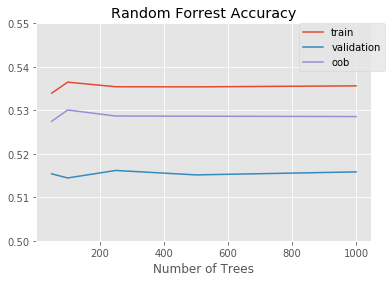

In [55]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Now let's looks at the average feature importance of the classifiers.

In [56]:
print('Features Ranked by Average Importance:\n')
project_helper.rank_features_by_importance(np.average(feature_importances, axis=0), features)

Features Ranked by Average Importance:

      Feature                                         Importance
 1. Momentum_1YR                                (0.11413807504671884)
 2. dispersion_20d                              (0.10708811313173734)
 3. sector_Healthcare                           (0.08352279171923385)
 4. volatility_20d                              (0.0829456334348396)
 5. sector_Real Estate                          (0.07967984514211239)
 6. market_vol_120d                             (0.07595415210155033)
 7. Mean_Reversion_5Day_Sector_Neutral_Smoothed (0.07332216461073925)
 8. market_vol_20d                              (0.0700575331956212)
 9. adv_20d                                     (0.06801460840811416)
10. adv_120d                                    (0.05683322630862192)
11. dispersion_120d                             (0.04892592119788008)
12. sector_Financial Services                   (0.03830780785867055)
13. Overnight_Sentiment_Smoothed                (0.033552

Some of the features has low to no importance. We will be removing them when training the final model.

### Model Results
Let's look at some additional metrics to see how well a model performs. We've created the function `show_sample_results` to show the following results of a model:
- Sharpe Ratios
- Factor Returns
- Factor Rank Autocorrelation

In [57]:
import alphalens as al


all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = get_pricing(
    data_portal,
    trading_calendar,
    all_assets,
    factor_start_date,
    universe_end_date)

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_ALPHA'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = project_helper.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = project_helper.get_factor_returns(factor_data)
    sharpe_ratio = project_helper.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    project_helper.plot_factor_returns(factor_returns)
    project_helper.plot_factor_rank_autocorrelation(factor_data)

#### Results
Let's compare our AI Alpha factor to a few other factors. We'll use the following:

In [58]:
factor_names = [
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed',
    'Momentum_1YR',
    'Overnight_Sentiment_Smoothed',
    'adv_120d',
    'volatility_20d']

##### Training Prediction
Let's see how well the model runs on training data.

Cleaning Data...

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

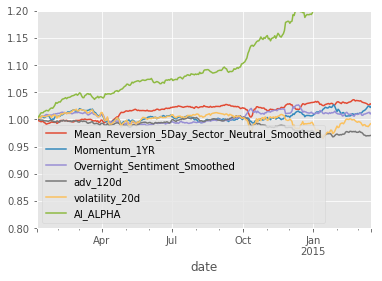

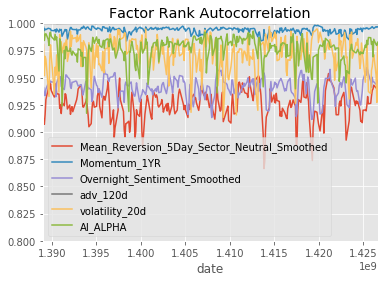

In [59]:
show_sample_results(all_factors, X_train, clf, factor_names)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

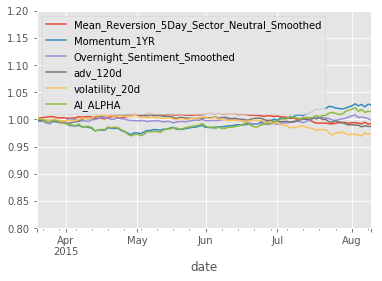

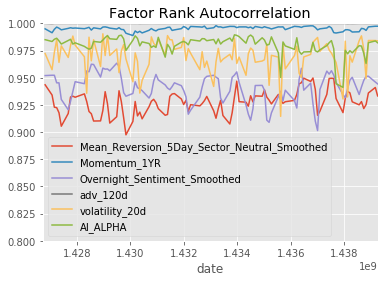

In [60]:
show_sample_results(all_factors, X_valid, clf, factor_names)

So that's pretty extraordinary. Even when the input factor returns are sideways to down, the AI Alpha is positive with Sharpe Ratio > 2. If we hope that this model will perform well in production we need to correct though for the non-IID labels and mitigate likely overfitting.

## Overlapping Samples
Let's fix this by removing overlapping samples. We can do a number of things:

- Don't use overlapping samples
- Use BaggingClassifier's `max_samples`
- Build an ensemble of non-overlapping trees

In this project, we'll do all three methods and compare.
### Drop Overlapping Samples
This is the simplest of the three methods. We'll just drop any overlapping samples from the dataset. Implement the `non_overlapping_samples` function to return a new dataset overlapping samples. 

In [61]:
def non_overlapping_samples(x, y, n_skip_samples, start_i=0):
    """
    Get the non overlapping samples.

    Parameters
    ----------
    x : DataFrame
        The input samples
    y : Pandas Series
        The target values
    n_skip_samples : int
        The number of samples to skip
    start_i : int
        The starting index to use for the data
    
    Returns
    -------
    non_overlapping_x : 2 dimensional Ndarray
        The non overlapping input samples
    non_overlapping_y : 1 dimensional Ndarray
        The non overlapping target values
    """
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    
    idx = x.index.get_level_values(level=0).unique().tolist()[start_i::n_skip_samples+1]
    non_overlapping_x = x.loc[idx]
    non_overlapping_y = y.loc[idx]
    return non_overlapping_x, non_overlapping_y


#project_tests.test_non_overlapping_samples(non_overlapping_samples)

With the dataset created without overlapping samples, lets train a new model and look at the results.

#### Train Model

In [62]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(*non_overlapping_samples(X_train, y_train, 4))
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)

Training Models: 100%|██████████| 5/5 [00:56<00:00, 11.38s/Model]


#### Results

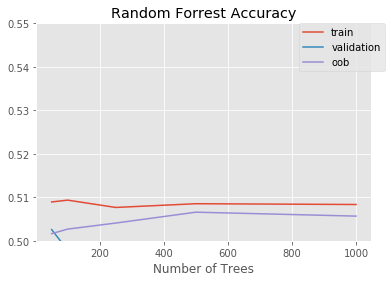

In [63]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

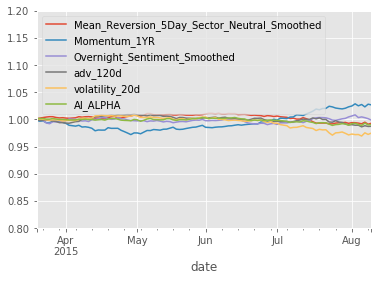

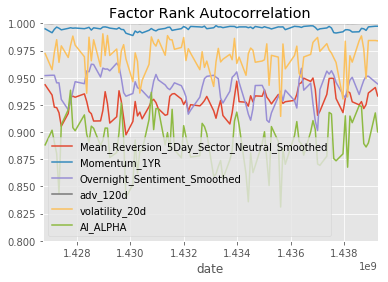

In [64]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This looks better, but we are throwing away a lot of information by taking every 5th row.

### Use BaggingClassifier's `max_samples`
In this method, we'll set `max_samples` to be on the order of the average uniqueness of the labels. Since  `RandomForrestClassifier` does not take this param, we're using `BaggingClassifier`. Implement `bagging_classifier` to build the bagging classifier.

In [66]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


def bagging_classifier(n_estimators, max_samples, max_features, parameters):
    """
    Build the bagging classifier.

    Parameters
    ----------
    n_estimators : int 
        The number of base estimators in the ensemble
    max_samples : float 
        The proportion of input samples drawn from when training each base estimator
    max_features : float 
        The proportion of input sample features drawn from when training each base estimator
    parameters : dict
        Parameters to use in building the bagging classifier
        It should contain the following parameters:
            criterion
            min_samples_leaf
            oob_score
            n_jobs
            random_state
    
    Returns
    -------
    bagging_clf : Scikit-Learn BaggingClassifier
        The bagging classifier
    """
    
    required_parameters = {'criterion', 'min_samples_leaf', 'oob_score', 'n_jobs', 'random_state'}
    assert not required_parameters - set(parameters.keys())
    
    # TODO: Implement
    base_clf = DecisionTreeClassifier(
        criterion=parameters['criterion'],
        max_features=max_features,
        min_samples_leaf= parameters['min_samples_leaf']
    )
    bagging_clf = BaggingClassifier(
        base_estimator = base_clf,
        n_estimators = n_estimators,
        max_samples = max_samples,
        bootstrap=True,
        oob_score=parameters['oob_score'],
        n_jobs=parameters['n_jobs'],
        verbose=0,
        random_state=parameters['random_state']
    )
    return bagging_clf

With the bagging classifier built, lets train a new model and look at the results.
#### Train Model

In [67]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = bagging_classifier(n_trees, 0.2, 1.0, clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
#I got disconnected three times for running this model

Training Models: 100%|██████████| 5/5 [06:41<00:00, 80.40s/Model]


#### Results

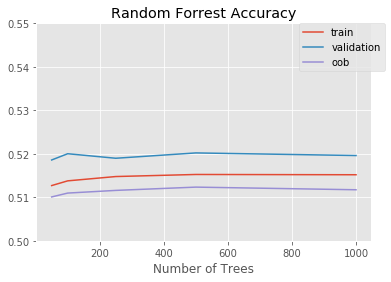

In [68]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

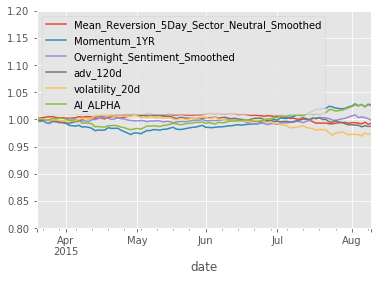

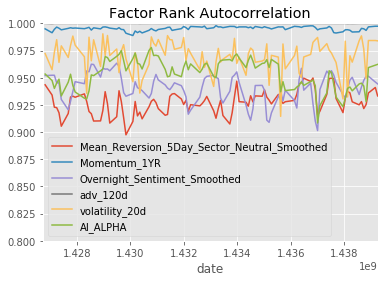

In [69]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This seems much "better" in the sense that we have much better fidelity between the three.


### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [70]:
import abc

from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

You might notice that two of the functions are abstracted. These will be the functions that you need to implement.
#### OOB Score
In order to get the correct OOB score, we need to take the average of all the estimator's OOB scores. Implement `calculate_oob_score` to calculate this score.

In [71]:
def calculate_oob_score(classifiers):
    """
    Calculate the mean out-of-bag score from the classifiers.

    Parameters
    ----------
    classifiers : list of Scikit-Learn Classifiers
        The classifiers used to calculate the mean out-of-bag score
    
    Returns
    -------
    oob_score : float
        The mean out-of-bag score
    """
    
    # TODO: Implement
    oob_scores = [classifier.oob_score_ for classifier in classifiers]
    return np.mean(oob_scores)


#project_tests.test_calculate_oob_score(calculate_oob_score)

#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

In [72]:
def non_overlapping_estimators(x, y, classifiers, n_skip_samples):
    """
    Fit the classifiers to non overlapping data.

    Parameters
    ----------
    x : DataFrame
        The input samples
    y : Pandas Series
        The target values
    classifiers : list of Scikit-Learn Classifiers
        The classifiers used to fit on the non overlapping data
    n_skip_samples : int
        The number of samples to skip
    
    Returns
    -------
    fit_classifiers : list of Scikit-Learn Classifiers
        The classifiers fit to the the non overlapping data
    """
    
    # TODO: Implement
    assert len(classifiers) <= n_skip_samples + 1
    model_datas = [[classifiers[i] ,non_overlapping_samples(x,y,n_skip_samples,i)] for i in range(len(classifiers))]
    fit_classifiers = [model_data[0].fit(model_data[1][0], model_data[1][1]) for model_data in model_datas]
    return fit_classifiers


#project_tests.test_non_overlapping_estimators(non_overlapping_estimators)

In [73]:
class NoOverlapVoter(NoOverlapVoterAbstract):
    def _calculate_oob_score(self, classifiers):
        return calculate_oob_score(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        return non_overlapping_estimators(x, y, classifiers, n_skip_samples)

Now that we have our `NoOverlapVoter` class, let's train it.

#### Train Model

In [74]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|██████████| 5/5 [03:42<00:00, 44.57s/Model]


#### Results

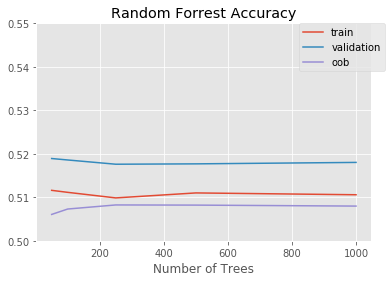

In [75]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

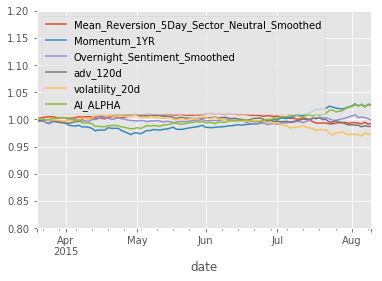

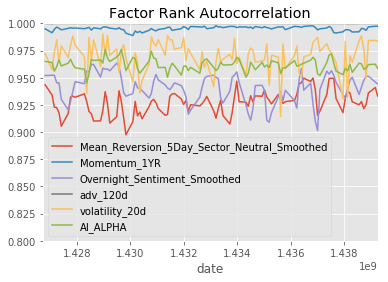

In [76]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [77]:
n_trees = 500

clf = RandomForestClassifier(n_trees, **clf_parameters)
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

NoOverlapVoter(estimator=None, n_skip_samples=4, voting='soft')

### Results
#### Accuracy

In [78]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

train: 0.510065284553982, oob: 0.524012474012474, valid: 0.5107818759203304


#### Train

Cleaning Data...

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

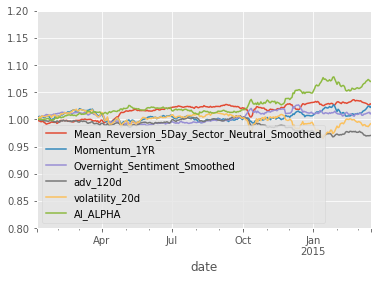

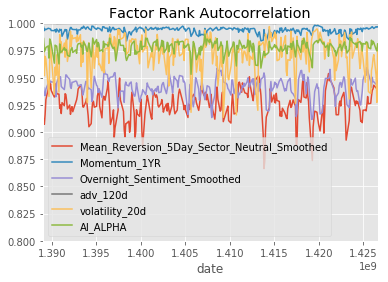

In [79]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

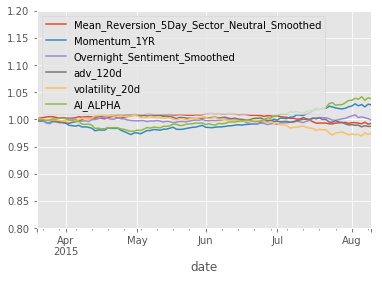

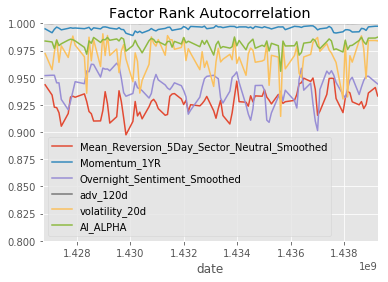

In [80]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

#### Test

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

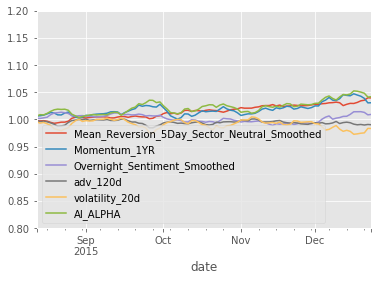

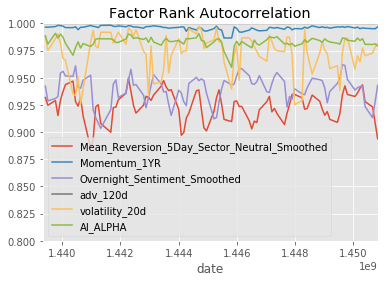

In [81]:
show_sample_results(all_factors, X_test, clf_nov, factor_names)

## The Combined Alpha Vector
### Use Random Forest Model
Here, we will use random forest model to predict the combined alpha factor for the proposed end date of the universe
`get_alpha_vector` will make use of random forest prediction given the features are for the last day

In [82]:
def get_alpha_vector(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_ALPHA'
    all_factors = data.loc[samples.index].copy()
    all_factors[alpha_score_label] = alpha_score
    alphas = all_factors[[alpha_score_label]]
    #Get the last date
    alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
    return alpha_vector

In [83]:
alpha_vector = get_alpha_vector(all_factors, X_test, clf_nov, factor_names)

# Project 7 End

# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [85]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [86]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        
        return cvx.Maximize(alpha_vector.T.values @ weights)
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        #TODO: Implement function
        constraints =[risk <= self.risk_cap**2,
                     factor_betas.T @ weights <= self.factor_max,
                     factor_betas.T @ weights >= self.factor_min,
                     sum(weights) == 0,
                     sum(cvx.abs(weights)) <=1.0,
                     weights >= self.weights_min,
                     weights <= self.weights_max]
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


project_tests.test_optimal_holdings_get_obj(OptimalHoldings)
project_tests.test_optimal_holdings_get_constraints(OptimalHoldings)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed

Running Integration Test on Problem.solve:
> x = np.diag(np.arange(3))
> s = np.diag(np.arange(4))
> factor_betas = np.arange(4 * 3).reshape([4, 3])
> risk = cvx.quad_form(weights * factor_betas, x) + cvx.quad_form(weights, s)
> constaints = optimal_holdings._get_constraints(weights, factor_betas, risk)
> obj = cvx.Maximize([0, 1, 5, -1] * weights)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


/opt/conda/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/opt/conda/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

/opt/conda/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


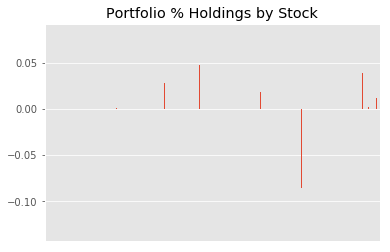

In [87]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Yikes. It put most of the weight in a few stocks.

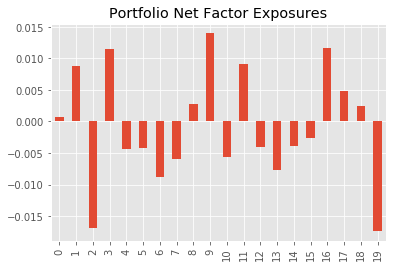

In [88]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [89]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        
        return cvx.Maximize(alpha_vector.T.values @ weights - self.lambda_reg * cvx.norm(weights,2))

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min
        

project_tests.test_optimal_holdings_regualization_get_obj(OptimalHoldingsRegualization)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_regualization._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

/opt/conda/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


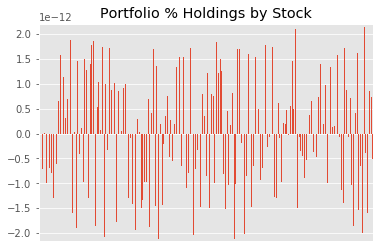

In [90]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Nice. Well diversified.

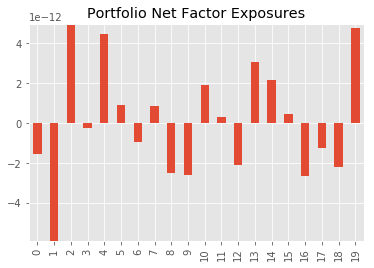

In [91]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [92]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        x_target = (alpha_vector - alpha_vector.mean())/sum(abs(alpha_vector.values))
        return cvx.Minimize(cvx.norm(weights - x_target.values.reshape(-1),2))


project_tests.test_optimal_holdings_strict_factor_get_obj(OptimalHoldingsStrictFactor)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_strict_factor._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

/opt/conda/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


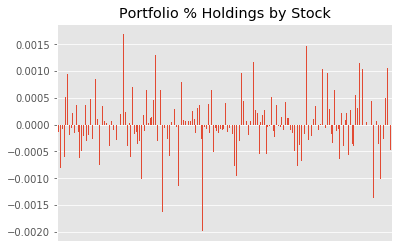

In [93]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

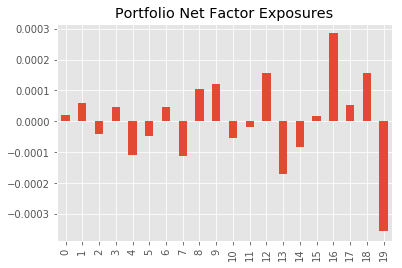

In [94]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)